# ScrapyDo Overview

[ScrapyDo](https://github.com/darkrho/scrapydo) is a [crochet](https://github.com/itamarst/crochet)-based blocking API for [Scrapy](http://scrapy.org). It allows the usage of Scrapy as a library, mainly aimed to be used in spiders prototyping and data exploration in [IPython notebooks](http://ipython.org/notebook.html).

In this notebook we are going to show how to use `scrapydo` and how it helps to rapidly crawl and explore data. Our main premise is that we want to crawl the internet as a mean to analysis data and not as an end.

## Initialization

The function `setup` must be called before any call to other functions.

In [1]:
import scrapydo
scrapydo.setup()

## The `fetch` function and highlight helper

The `fetch` function returns a `scrapy.Response` object for a given URL.

In [2]:
response = scrapydo.fetch("http://httpbin.org/get?show_env=1")
response

<200 http://httpbin.org/get?show_env=1>

The `highlight` function is a helper to highlight text content using the [pygments](http://pygments.org) module. It is very useful to inspect text content.

In [3]:
from scrapydo.utils import highlight
highlight(response.body, 'json')

In [4]:
response = scrapydo.fetch("http://httpbin.org")
highlight(response.body[:300])

In [5]:
highlight(response.css('p').extract())

In [6]:
highlight(response.headers, 'python')

## The `crawl` function or how to do spider-less crawling

Here we are going to show to crawl an URL without defining a spider class and only using callback functions. This is very useful for quick crawling and data exploration.

In [7]:
# Some additional imports for our data exploration.
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
sns.set(context='poster', style='ticks')

We replicate the example in [scrapy.org](http://scrapy.org), by defining two callbacks functions to crawl the website http://blog.scrapinghub.com.
    
The function `parse_blog(response)` is going to extract the listing URLs and the function `parse_titles(response)` is going to extract the post titles from each listing page.

In [8]:
import scrapy

def parse_blog(response):
    for url in response.css('ul li a::attr("href")').re(r'/\d\d\d\d/\d\d/$'):
        yield scrapy.Request(response.urljoin(url), parse_titles)

def parse_titles(response):
    for post_title in response.css('div.entries > ul > li a::text').extract():
        yield {'title': post_title}

Once we have our callback functions for our target website, we simply call to `scrapydo.crawl`:

In [9]:
items = scrapydo.crawl('http://blog.scrapinghub.com', parse_blog)

Now that we have our data, we can start doing the fun part! Here we show the posts title length distribution.

In [10]:
df = pd.DataFrame(items)
df['length'] = df['title'].apply(len)
df[:5]

,title,length
0,EuroPython 2015 on,18
1,StartupChats Remote Working Q&A on,34
2,PyCon Philippines 2015 on,25
3,Why MongoDB Is a Bad Choice for Storing Our Sc...,59
4,"Introducing Crawlera, a Smart Page Downloader on",48


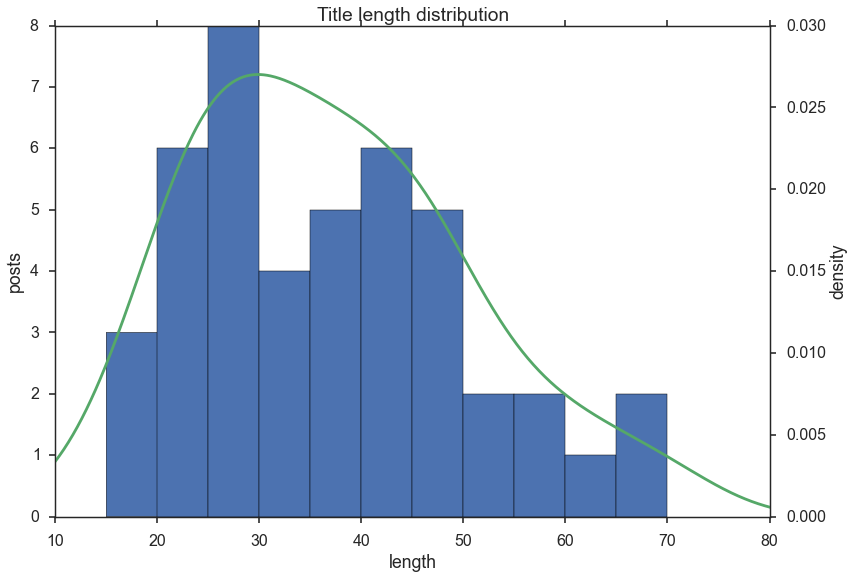

In [11]:
ax = df['length'].plot(kind='hist', bins=11)
ax2 = df['length'].plot(kind='kde', secondary_y=True, ax=ax)
ax2.set(ylabel="density")
ax.set(title="Title length distribution", xlim=(10, 80), ylabel="posts", xlabel="length");

## The `run_spider` function and running spiders from an existing project

The previous section showed how to do quick crawls to retrieve data. In this section we are going to show how to run spiders from existing scrapy projects, which can be useful for rapid spider prototyping as well as analysing the crawled data from a given spider.

We use a modified [dirbot](https://github.com/scrapy/dirbot/) project, which is already accesible through the `PYTHONPATH`.

In [12]:
import os
os.environ['SCRAPY_SETTINGS_MODULE'] = 'dirbot.settings'

We want to see the logging output, just as the `scrapy crawl` command would do. Hence we set the log level to `INFO`.

In [13]:
import logging
logging.root.setLevel(logging.INFO)

The function `run_spider` allows to run any spider class and provide custom settings.

In [14]:
from dirbot.spiders import dmoz
items = scrapydo.run_spider(dmoz.DmozSpider, settings={'CLOSESPIDER_ITEMCOUNT': 500})

INFO:scrapy.utils.log:Scrapy 1.0.1 started (bot: scrapybot)
INFO:scrapy.utils.log:Optional features available: ssl, http11
INFO:scrapy.utils.log:Overridden settings: {'DEFAULT_ITEM_CLASS': 'dirbot.items.Website', 'CLOSESPIDER_ITEMCOUNT': 500, 'SPIDER_MODULES': ['dirbot.spiders'], 'NEWSPIDER_MODULE': 'dirbot.spiders'}
INFO:scrapy.middleware:Enabled extensions: CoreStats, TelnetConsole, LogStats, CloseSpider, SpiderState
INFO:scrapy.middleware:Enabled downloader middlewares: HttpAuthMiddleware, DownloadTimeoutMiddleware, UserAgentMiddleware, RetryMiddleware, DefaultHeadersMiddleware, MetaRefreshMiddleware, HttpCompressionMiddleware, RedirectMiddleware, CookiesMiddleware, ChunkedTransferMiddleware, DownloaderStats
INFO:scrapy.middleware:Enabled spider middlewares: HttpErrorMiddleware, OffsiteMiddleware, RefererMiddleware, UrlLengthMiddleware, DepthMiddleware
INFO:scrapy.middleware:Enabled item pipelines: FilterWordsPipeline, DefaultFields
INFO:scrapy.core.engine:Spider opened
INFO:scrapy.

In this way, we have less friction to use scrapy to data mine the web and quickly start exploring our data. 

In [15]:
highlight(items[:3], 'python')

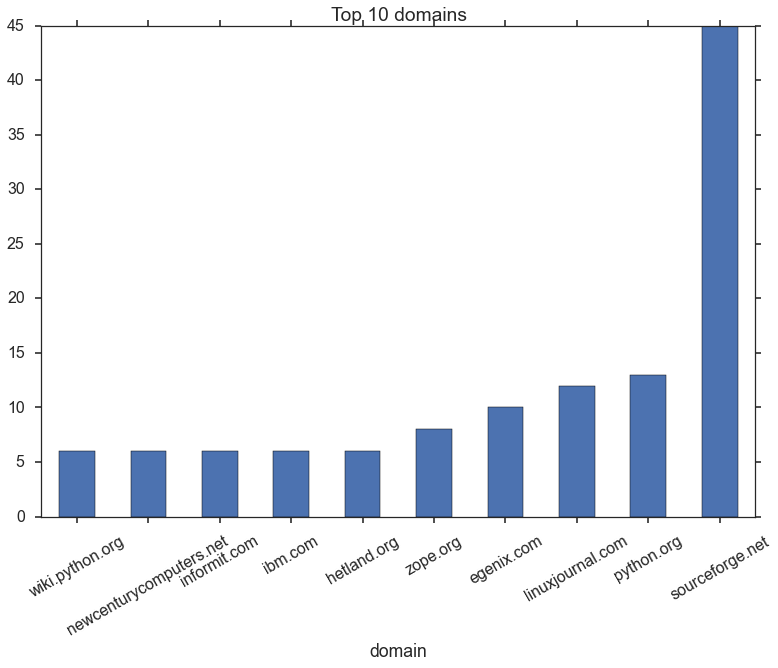

In [16]:
from urlparse import urlparse
dmoz_items = pd.DataFrame(items)
dmoz_items['domain'] = dmoz_items['url'].apply(lambda url: urlparse(url).netloc.replace('www.', ''))
ax = dmoz_items.groupby('domain').apply(len).sort(inplace=False)[-10:].plot(kind='bar')
ax.set(title="Top 10 domains")
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30);

## Closing remarks

[Scrapy](http://scrapy.org) is an excellent framework for crawling the web, however it's usage can be a bit overwhelming for users that just want to quickly scrape the data and start doing stuff, in this scenario [ScrapyDo](https://github.com/darkrho/scrapydo) provides a simplified API to start using [Scrapy](http://scrapy.org) in a straightfoward way.

Happy data hacking!